In [1]:
from torch.nn import CrossEntropyLoss
from torch.autograd import set_detect_anomaly
from torch.cuda.amp import autocast, GradScaler
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch import device, eq, unique, save, load, no_grad
from torch.cuda import is_available
from numpy.random import randint
from numpy import NINF
from pandas import DataFrame
import time
import os
from IPython.display import clear_output

from model import get_model
from configs import get_512_modified_mixer_b16_config, get_cityscapes_config
from utils import display
from input_piplines import get_cityscapes_loader

TOTAL_EPOCHS = 200
CSV_DIR = './training_record_224.csv'
CHECKPOINT_DIR = './experiment_checkpoint'
CHECKPOINT_FILE = CHECKPOINT_DIR + '/highest_accuracy_ckpt'

#device = device("cpu")
device = device("cuda" if is_available() else "cpu")
print("Using {} device".format(device))

train_dataloader, test_dataloader = get_cityscapes_loader(get_cityscapes_config())

model = get_model(get_512_modified_mixer_b16_config()).cuda()
#model.to(device)
set_detect_anomaly(True)

loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-5)
lmbda = lambda epoch: 0.96 ** epoch
scheduler = LambdaLR(optimizer, lr_lambda=lmbda)
scaler = GradScaler()

if not os.path.isfile(CSV_DIR):
    data = DataFrame(columns=['Epoch', 'Validation Loss', 'Validation Accuracy'])
    data.to_csv(CSV_DIR, index=False)
    
def train(dataloader, model, loss_fn, optimizer, scheduler, scaler):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        with autocast():
        # Compute prediction error
            pred = model(X)
            y = y.squeeze(1).long()
            loss = loss_fn(pred, y)

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scheduler.step()
        
        scaler.update()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, current_epoch, writing_dir=None, sleep_and_clear=True):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    x = randint(0, high=size-1)
    vis = model(dataloader.dataset[x][0].to(device)).argmax(1)
    vis = (vis*255).byte()
    display([dataloader.dataset[x][0], dataloader.dataset[x][1], vis])
    model.eval()
    test_loss, correct = 0, 0
    
    with no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.squeeze(1).long()).item()
            bool_tensor = eq(pred.argmax(1).long(), y.squeeze(1).long())
            _ ,acc_mat = unique(bool_tensor, return_counts=True)
            correct += acc_mat[1].item()/(acc_mat[0].item() + acc_mat[1].item())
            
    test_loss /= num_batches
    correct /= size
    correct = correct*100
    print(f"Test Error: \n Pixel-wise accuracy: {correct}%, Average loss: {test_loss} \n")
    
    if writing_dir is not None:    
        current_data = DataFrame([[current_epoch, correct, test_loss]])
        current_data.to_csv(writing_dir, index=False, mode='a', header=False)
    
    if sleep_and_clear:   
        time.sleep(3)
        clear_output()
    
    return correct
            


#Train new model
if not os.listdir(CHECKPOINT_DIR):
    print("No checkpoint is detected in experiment_checkpoint folder, training from begining")
    init_acc = NINF
    
    for t in range(TOTAL_EPOCHS):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer, scheduler, scaler)
        current_acc = test(test_dataloader, model, loss_fn, t+1, writing_dir=CSV_DIR)
        if current_acc > init_acc:
            init_acc = current_acc
            save({
            'epoch': t+1,
            'model_state_dict': model.state_dict(),
            'testing_accuracy': current_acc
            }, CHECKPOINT_FILE)
    
    save(model, f"./full_model/epoch_{total_epochs}")
            
#Training from checkpoint
else:
    checkpoint = load(CHECKPOINT_FILE)
    print(f"Checkpoint loaded, last epoch is: {checkpoint['epoch']}, testing accuracy: {checkpoint['testing_accuracy']}%")
    model.load_state_dict(checkpoint['model_state_dict'])
    init_acc = NINF
    
    for t in range(checkpoint['epoch'], TOTAL_EPOCHS):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer, scheduler, scaler)
        current_acc = test(test_dataloader, model, loss_fn, t+1, writing_dir=CSV_DIR)
        if current_acc > init_acc:
            init_acc = current_acc
            save({
            'epoch': t+1,
            'model_state_dict': model.state_dict(),
            'testing_accuracy': current_acc
            }, CHECKPOINT_FILE)
    
    save(model, f"./full_model/epoch_{total_epochs}")

Epoch 47
-------------------------------
Loss: 2.057082  [    0/ 2975]


KeyboardInterrupt: 

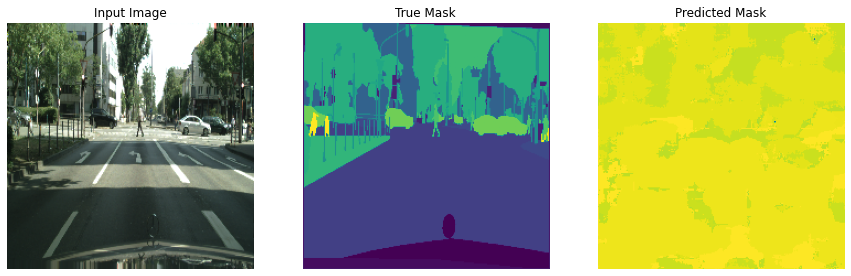

Test Error: 
 Pixel-wise accuracy: 1.051283561862245%, Average loss: 2.121747362613678 



1.051283561862245

In [2]:
val_dataloader = get_cityscapes_loader(get_cityscapes_config(), load_val=True)
test(val_dataloader, model, loss_fn, 1, sleep_and_clear=False)